In [213]:

import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

crit_thresh = -0.084337
warn_thresh = -0.036689
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
#crit_thresh = -0.094870
#warn_thresh = -0.042534

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler2.joblib')
iso_model = load('./model/iso_model2.joblib')

# Load datasets
#df_val = pd.read_csv("./data/validate.csv")
#df_val = pd.read_csv("./data/devAll2_prepared.csv")
#df1 = pd.read_csv("./data/dev101_prepared.csv")
#df2 = pd.read_csv("./data/dev102_prepared.csv")

#df_val = pd.concat([df1, df2], ignore_index=True)
df_val = pd.read_csv("./../../data/dataSet1_prepared.csv")
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [214]:
df_val

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933,11,4
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010,11,4
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933,11,4
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010,11,4
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933,11,4
...,...,...,...,...,...,...,...,...,...,...,...
375604,2025-07-22 19:39:28.596,101.0,25.600000,0.0,28.682386,74.146103,7.982772,8.638018,99.898956,19,1
375605,2025-07-22 19:39:35.152,102.0,23.299999,0.0,28.653008,73.873352,5.533101,8.637944,99.898926,19,1
375606,2025-07-22 19:39:41.789,101.0,25.600000,0.0,28.674376,74.270081,0.931764,8.638016,99.898956,19,1
375607,2025-07-22 19:39:48.552,102.0,23.299999,0.0,28.631645,73.905777,6.762322,8.637944,99.898926,19,1


In [215]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
count,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000
mean,101.502898,43.992966,0.165806,29.900678,74.567455,8.239718,8.637978,99.901333,11.508755,3.100647
std,0.499992,13.708053,1.579886,3.189388,8.844493,6.654768,0.000038,1.461406,7.050659,1.968851
min,101.000000,20.200001,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664,0.000000,0.000000
25%,101.000000,28.500000,0.000000,27.397957,68.698631,3.001680,8.637944,99.898926,5.000000,1.000000
50%,102.000000,46.799999,0.000000,28.586250,78.603645,4.549040,8.637974,99.898949,12.000000,3.000000
75%,102.000000,56.000000,0.000000,32.695885,80.863892,13.630129,8.638015,99.898972,18.000000,5.000000
max,102.000000,66.599998,41.630600,39.331657,88.510567,32.062466,8.638361,995.549988,23.000000,6.000000


## Threshold

In [216]:
#def rule_based_risk(row):
#   score = 0
#   
#   # Rainfall (mm/h)
#   if row['rain'] > 25:
#       score += 2
#   elif row['rain'] > 10:
#       score += 1
#
#   # Soil moisture (%)
#   if row['soil'] > 60:
#       score += 2
#   elif row['soil'] > 45:
#       score += 1
#
#   # Temperature (°C)
#   if row['temp'] < 27:
#       score += 2
#   elif row['temp'] < 32:
#       score += 1
#
#   # Humidity (%)
#   if row['humi'] > 80:
#       score += 2
#   elif row['humi'] > 65:
#       score += 1
#
#   # Geophone (Hz)
#   if row['geo'] > 25:
#       score += 1
#   elif row['geo'] > 10:
#       score += 0.5
#
#   if score >= 6:
#       return "Critical"
#   elif score >= 3:
#       return "Warning"
#   else:
#       return "Normal"
#
#feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
#X_val = df_val[feature_cols].values
#X_val_scaled = scaler.transform(X_val)
#
#df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
#
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.5)
#warn_thresh = np.percentile(df_val['anomaly_score'], 5)
#
#def model_based_risk(score):
#   if score < crit_thresh:
#       return "Critical"
#   elif score < warn_thresh:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['model_risk'] = df_val['anomaly_score'].apply(model_based_risk)
#df_val['rule_risk'] = df_val.apply(rule_based_risk, axis=1)
#
#risk_levels = {'Normal': 0, 'Warning': 1, 'Critical': 2}
#
#def combine_weighted_risks(model_risk, rule_risk, w_model=0.6, w_rule=0.4):
#   score = w_model * risk_levels[model_risk] + w_rule * risk_levels[rule_risk]
#   
#   if score >= 1.5:
#       return "Critical"
#   elif score >= 0.5:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['predicted_risk'] = df_val.apply(
#    lambda row: combine_weighted_risks(row['model_risk'], row['rule_risk']),
#    axis=1
#)
#
#print(df_val[['soil', 'rain', 'temp', 'humi', 'geo',
#              'anomaly_score', 'model_risk', 'rule_risk', 'predicted_risk']].head())

In [217]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'hour']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)




def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)

print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.4))
print("warn_thresh:", np.percentile(df_val['anomaly_score'], 1))

crit_thresh: -0.07671795769491765
warn_thresh: -0.044600447844091305


In [218]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
              soil         rain         temp         humi          geo  \
count  1056.000000  1056.000000  1056.000000  1056.000000  1056.000000   
mean     58.439962    16.052006    27.121303    81.162481    22.918839   
std       8.508655     9.020637     1.898810     3.992634     8.667502   
min      20.900000     0.000000    24.949266    49.691616     0.656139   
25%      54.200001     9.779000    26.220339    80.701767    18.179222   
50%      61.700001    15.646400    26.709011    81.322617    19.817020   
75%      64.300003    19.837400    27.537479    81.857636    31.988949   
max      66.599998    41.630600    37.961777    88.413284    32.061317   

              hour  
count  1056.000000  
mean      7.690341  
std       6.427558  
min       0.000000  
25%       2.000000  
50%       7.000000  
75%       9.000000  
max      22.000000  


In [219]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
              soil         rain         temp         humi          geo  \
count  3598.000000  3598.000000  3598.000000  3598.000000  3598.000000   
mean     52.071262     7.879344    29.969207    73.928462    18.956846   
std      13.153949     9.357915     4.476237    11.530249    10.330623   
min      20.400000     0.000000    24.364462    43.418247     0.639543   
25%      51.099998     0.000000    26.506063    64.792805    12.422777   
50%      55.799999     5.588000    27.313843    80.615929    17.915962   
75%      60.900002    11.734800    35.291447    81.439442    31.983458   
max      66.400002    40.513000    39.222168    87.780045    32.062466   

              hour  
count  3598.000000  
mean      9.131184  
std       6.730073  
min       0.000000  
25%       4.000000  
50%       8.000000  
75%      15.000000  
max      23.000000  


In [220]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
                soil           rain           temp           humi  \
count  370955.000000  370955.000000  370955.000000  370955.000000   
mean       43.873486       0.045767      29.907925      74.554879   
std        13.680029       0.369942       3.173828       8.817259   
min        20.200001       0.000000      24.238958      44.434883   
25%        28.100000       0.000000      27.408638      68.694817   
50%        46.700001       0.000000      28.604942      78.554054   
75%        55.799999       0.000000      32.690544      80.831467   
max        66.400002      11.734800      39.331657      88.510567   

                 geo           hour  
count  370955.000000  370955.000000  
mean        8.093982      11.542686  
std         6.468723       7.048496  
min         0.000000       0.000000  
25%         2.989943       5.000000  
50%         4.469224      12.000000  
75%        13.413853      18.000000  
max        32.062378      23.000000  


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


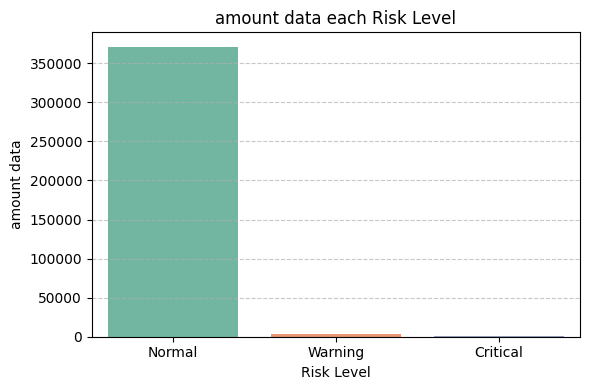

In [221]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

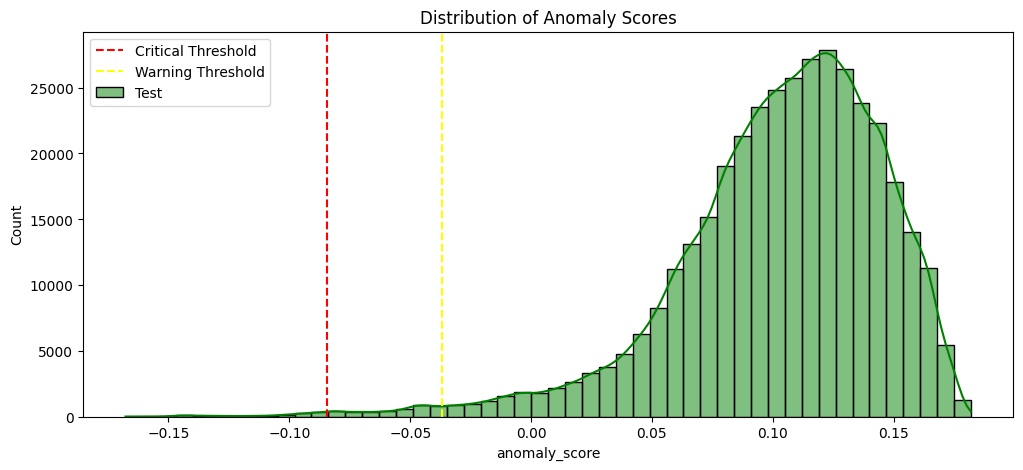

In [222]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## Z-score Outlier

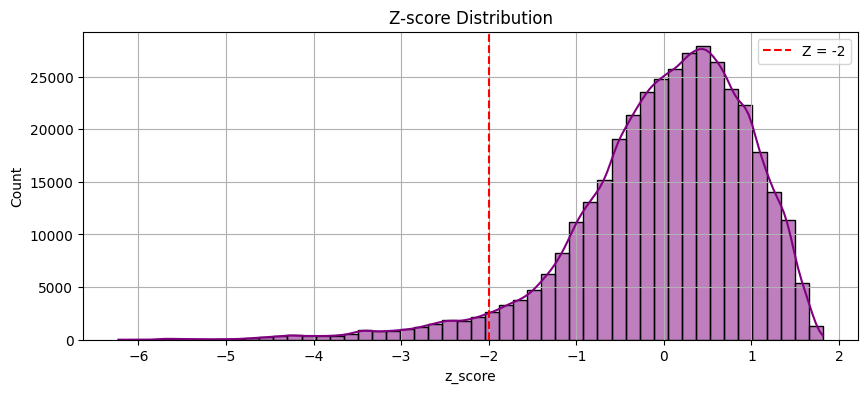

In [223]:
# ==== Z-score Outlier ====

mean_score = df_val['anomaly_score'].mean()
std_score = df_val['anomaly_score'].std()
df_val['z_score'] = (df_val['anomaly_score'] - mean_score) / std_score
df_val['z_outlier'] = df_val['z_score'].apply(lambda z: 'Anomaly' if z < -2 else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['z_score'], kde=True, bins=50, color='purple')
plt.axvline(-2, color='red', linestyle='--', label='Z = -2')
plt.title("Z-score Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Mahalanobis Distance

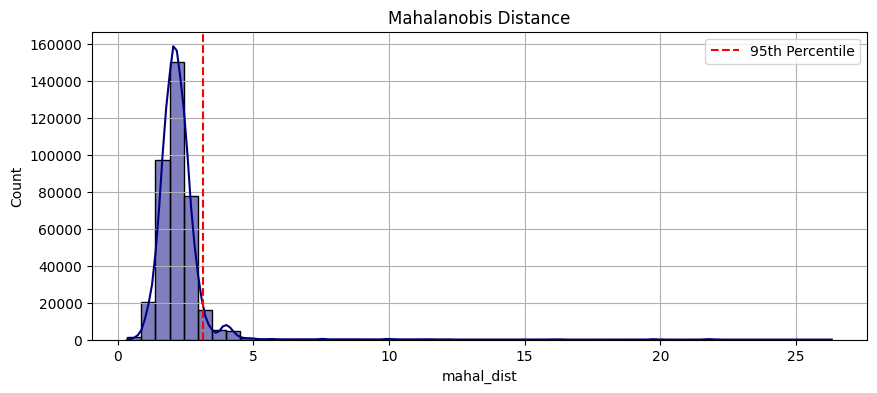

In [224]:
mean_vec = np.mean(X_val_scaled, axis=0)
cov_matrix = np.cov(X_val_scaled, rowvar=False)
inv_covmat = np.linalg.inv(cov_matrix)

df_val['mahal_dist'] = [mahalanobis(x, mean_vec, inv_covmat) for x in X_val_scaled]
mahal_thresh = np.percentile(df_val['mahal_dist'], 95)
df_val['mahal_outlier'] = df_val['mahal_dist'].apply(lambda d: 'Anomaly' if d > mahal_thresh else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['mahal_dist'], bins=50, kde=True, color='navy')
plt.axvline(mahal_thresh, color='red', linestyle='--', label='95th Percentile')
plt.title("Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()

## Percentile Threshold 5%

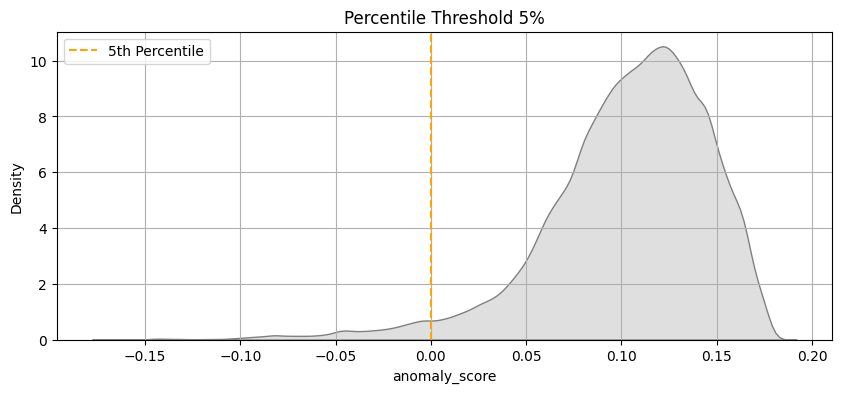

In [225]:
percentile = np.percentile(df_val['anomaly_score'], 3)
df_val['percentile_outlier'] = df_val['anomaly_score'].apply(lambda s: 'Anomaly' if s < percentile else 'Normal')

plt.figure(figsize=(10,4))
sns.kdeplot(df_val['anomaly_score'], fill=True, color='gray')
plt.axvline(percentile, color='orange', linestyle='--', label='5th Percentile')
plt.title("Percentile Threshold 5%")
plt.legend()
plt.grid(True)
plt.show()

## PCA

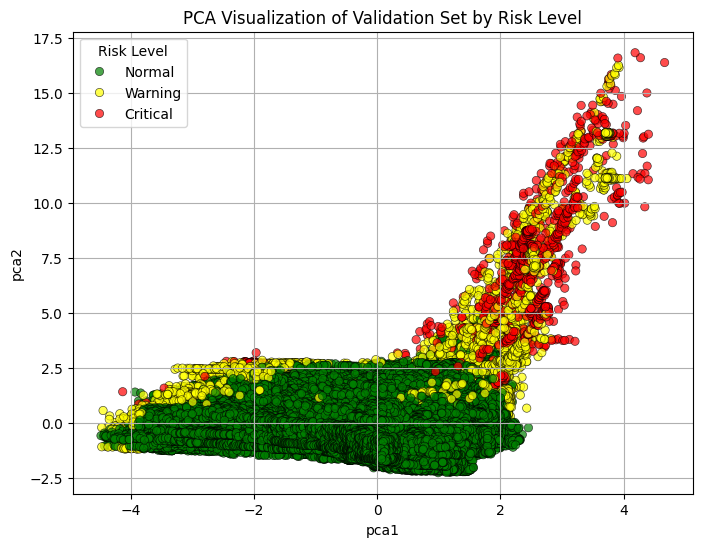

In [226]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [227]:
explained_var = pca.explained_variance_ratio_
print(f"PCA explain {explained_var[0]*100:.2f}% and {explained_var[1]*100:.2f}% of data")


PCA explain 33.76% and 19.27% of data


In [228]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
humi  0.676927 -0.047836
soil  0.210664  0.489370
hour  0.174913 -0.520841
rain  0.117498  0.574199
geo  -0.013345  0.391639
temp -0.672913  0.062192


## Summary Statistics

In [229]:
print("\n== Z-score Outlier ==")
print(df_val['z_outlier'].value_counts())


== Z-score Outlier ==
z_outlier
Normal     359664
Anomaly     15945
Name: count, dtype: int64


In [230]:
print("\n== Percentile Outlier ==")
print(f"5th Percentile Threshold: {percentile:.4f}")
print(df_val['percentile_outlier'].value_counts())


== Percentile Outlier ==
5th Percentile Threshold: -0.0000
percentile_outlier
Normal     364340
Anomaly     11269
Name: count, dtype: int64


In [231]:
print("\n== Mahalanobis Outlier ==")
print(f"95th Percentile of Mahalanobis Distance: {mahal_thresh:.2f}")
print(df_val['mahal_outlier'].value_counts())


== Mahalanobis Outlier ==
95th Percentile of Mahalanobis Distance: 3.16
mahal_outlier
Normal     356828
Anomaly     18781
Name: count, dtype: int64


In [232]:
overlap = df_val[
    (df_val['z_outlier'] == 'Anomaly') &
    (df_val['percentile_outlier'] == 'Anomaly') &
    (df_val['mahal_outlier'] == 'Anomaly')
]
print(f"Anomalies detected by ALL 3 methods: {len(overlap)}")


Anomalies detected by ALL 3 methods: 9211


In [233]:
df_val['combined_outlier'] = df_val.apply(
    lambda row: (
        row['z_outlier'] == 'Anomaly' or
        row['percentile_outlier'] == 'Anomaly' or
        row['mahal_outlier'] == 'Anomaly'
    ),
    axis=1
)

print("\n== Combined Outlier ==")
print(df_val['combined_outlier'].value_counts())


== Combined Outlier ==
combined_outlier
False    352274
True      23335
Name: count, dtype: int64


In [234]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo  \
predicted_risk                                                          
Critical        58.439962  16.052006  27.121303  81.162481  22.918839   
Normal          43.873486   0.045767  29.907925  74.554879   8.093982   
Warning         52.071262   7.879344  29.969207  73.928462  18.956846   

                     hour  
predicted_risk             
Critical         7.690341  
Normal          11.542686  
Warning          9.131184  


In [235]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      370955
Warning       3598
Critical      1056
Name: count, dtype: int64


In [236]:
def risk_from_combined(row):
    if row['combined_outlier']:
        if row['anomaly_score'] < crit_thresh:
            return 'Critical'
        elif row['anomaly_score'] < warn_thresh:
            return 'Warning'
        else:
            return 'Warning'  
    return 'Normal'

df_val['risk_level_final'] = df_val.apply(risk_from_combined, axis=1)
print("\n== risk level final ==")
print(df_val['risk_level_final'].value_counts())


== risk level final ==
risk_level_final
Normal      352274
Warning      22279
Critical      1056
Name: count, dtype: int64


In [237]:
print("\n== Risk final Proportion ==")
print("Validation:", df_val['risk_level_final'].value_counts(normalize=True))


== Risk final Proportion ==
Validation: risk_level_final
Normal      0.937874
Warning     0.059314
Critical    0.002811
Name: proportion, dtype: float64


In [238]:
print("\n== Risk Proportion ==")
print("Validation:", df_val['predicted_risk'].value_counts(normalize=True))


== Risk Proportion ==
Validation: predicted_risk
Normal      0.987609
Warning     0.009579
Critical    0.002811
Name: proportion, dtype: float64


##  Signal-to-Noise Ratio (SNR)

In [239]:
def compute_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal if std_signal != 0 else 0

for col in feature_cols:
    snr = compute_snr(df_val[col])
    print(f"SNR of {col}: {snr:.2f}")


SNR of soil: 3.21
SNR of rain: 0.10
SNR of temp: 9.38
SNR of humi: 8.43
SNR of geo: 1.24
SNR of hour: 1.63


In [240]:
for col in feature_cols:
    normal_snr = compute_snr(df_val[df_val['predicted_risk'] == 'Normal'][col])
    anomaly_snr = compute_snr(df_val[df_val['predicted_risk'] != 'Normal'][col])
    print(f"{col}: Normal SNR={normal_snr:.2f}, Anomaly SNR={anomaly_snr:.2f}")


soil: Normal SNR=3.21, Anomaly SNR=4.27
rain: Normal SNR=0.12, Anomaly SNR=0.98
temp: Normal SNR=9.42, Anomaly SNR=6.96
humi: Normal SNR=8.46, Anomaly SNR=7.03
geo: Normal SNR=1.25, Anomaly SNR=1.96
hour: Normal SNR=1.64, Anomaly SNR=1.32


## Mean Absolute Error (MAE)

In [241]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
interval = df_val['timestamp'].diff().median()
print(f"Sampling interval: {interval}")


Sampling interval: 0 days 00:00:07.404769500


In [242]:
window_size = int(pd.Timedelta('1H') / interval)
print(f"Rolling window size for 1 hour: {window_size}")


Rolling window size for 1 hour: 486


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\504831528.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


In [243]:
interval = df_val['timestamp'].diff().median()
window_size = int(pd.Timedelta('1H') / interval)

print(f"Using rolling window size = {window_size} for 1 hour")

for col in feature_cols:
    df_val[f'{col}_roll_mean'] = df_val[col].rolling(window=window_size, center=True).mean()
    df_val[f'{col}_mae'] = (df_val[col] - df_val[f'{col}_roll_mean']).abs()

    mae = df_val[f'{col}_mae'].mean()
    print(f"MAE for {col} (vs rolling mean): {mae:.2f}")


Using rolling window size = 486 for 1 hour
MAE for soil (vs rolling mean): 1.82
MAE for rain (vs rolling mean): 0.11
MAE for temp (vs rolling mean): 0.41
MAE for humi (vs rolling mean): 1.72
MAE for geo (vs rolling mean): 5.23
MAE for hour (vs rolling mean): 0.51


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\2248412977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


## Cross-Correlation

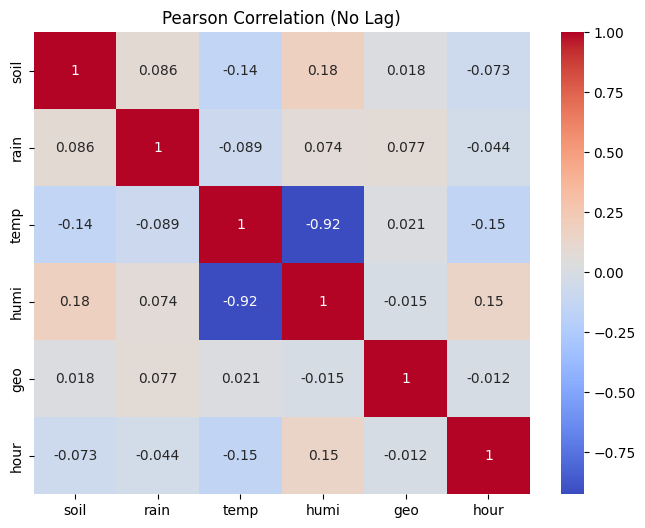

In [244]:
corr_matrix = df_val[feature_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation (No Lag)")
plt.show()

In [245]:
def lag_corr(x, y, max_lag=window_size*10):
    lags = []
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        lags.append(lag)
        corrs.append(corr)
    return lags, corrs


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\1202832202.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\1202832202.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


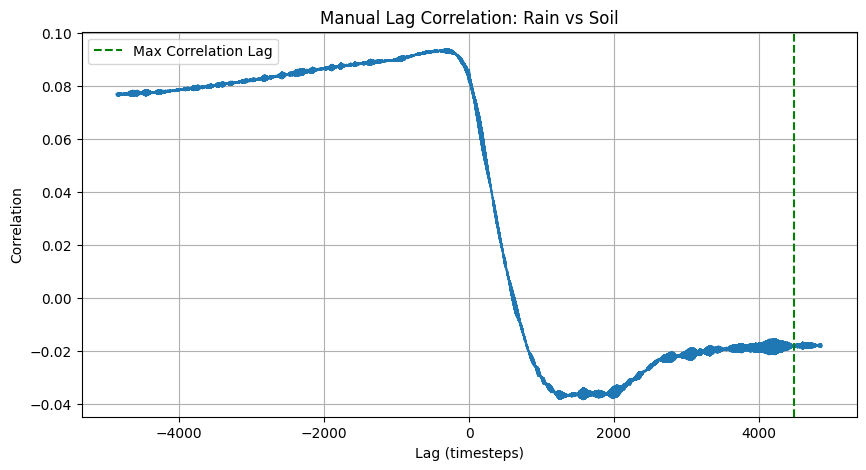

In [246]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values
lags, corrs = lag_corr(x, y, max_lag=window_size*10)

plt.figure(figsize=(10, 5))
plt.plot(lags, corrs)
plt.axvline(x=np.argmax(corrs) - 60, color='green', linestyle='--', label='Max Correlation Lag')
plt.title("Manual Lag Correlation: Rain vs Soil")
plt.xlabel("Lag (timesteps)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\3179048846.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\3179048846.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


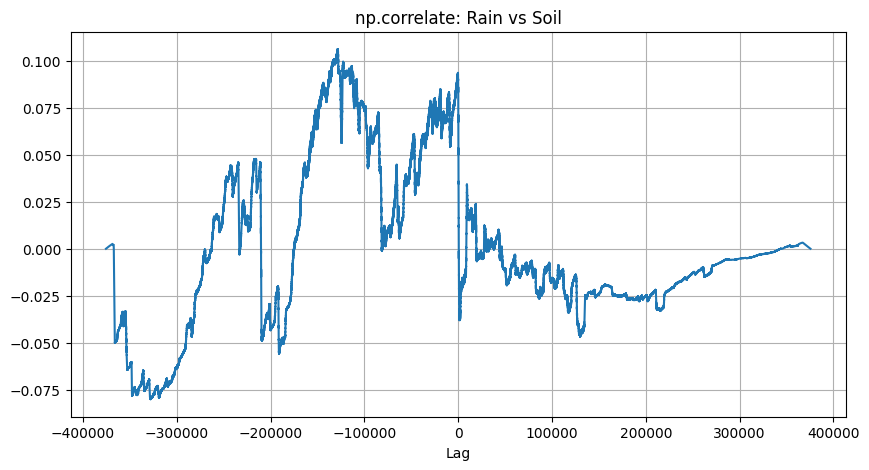

In [247]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

corr = np.correlate(x, y, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

plt.figure(figsize=(10,5))
plt.plot(lags, corr)
plt.title("np.correlate: Rain vs Soil")
plt.xlabel("Lag")
plt.grid(True)
plt.show()


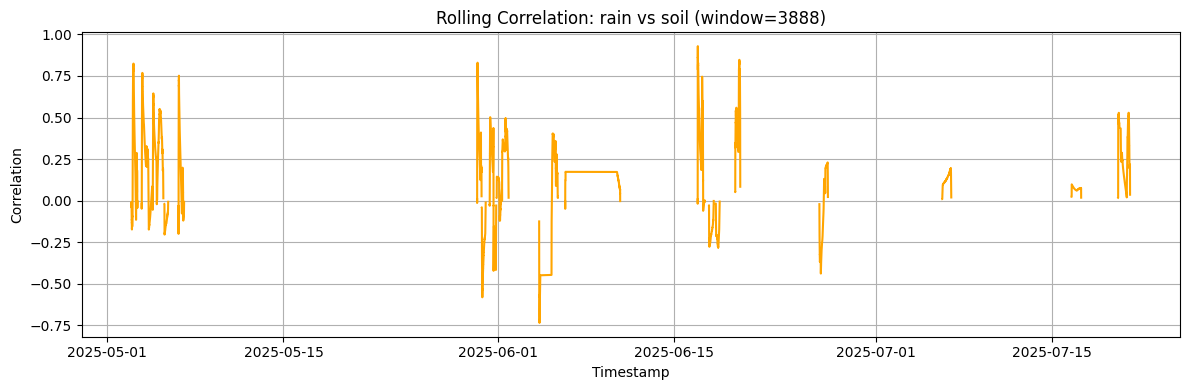

In [248]:
# ตัวอย่าง: ถ้า sampling ทุก 10 นาที → 48 จุด = 8 ชั่วโมง
df = df_val.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

rolling_corr = df['rain'].rolling(window_size*8).corr(df['soil'])

plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], rolling_corr, color='orange')
plt.title(f"Rolling Correlation: rain vs soil (window={window_size*8})")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

## histogram

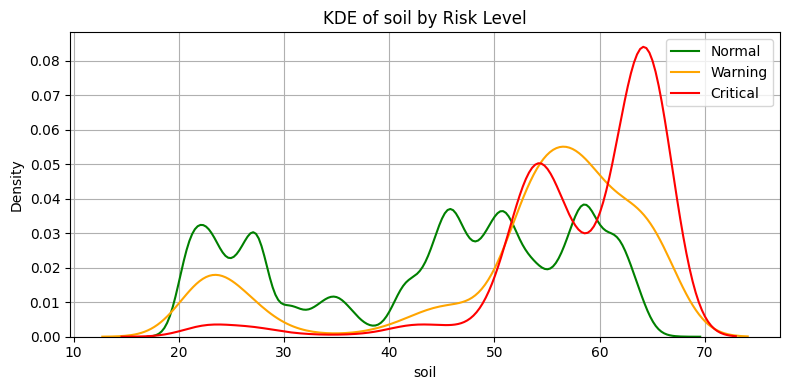

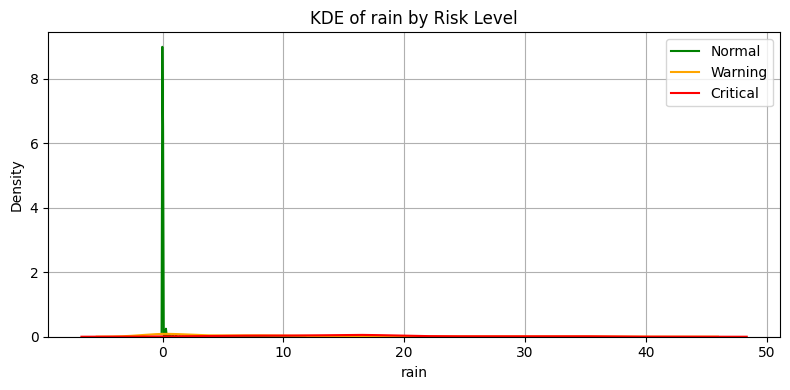

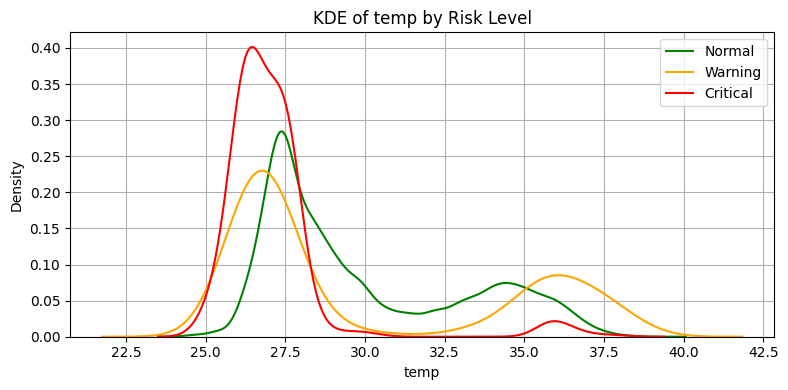

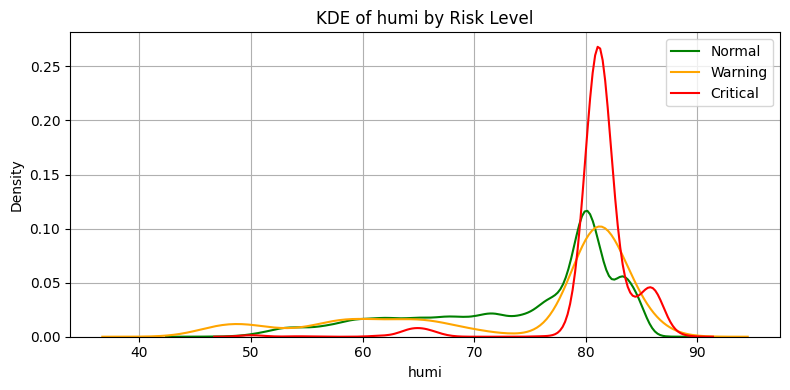

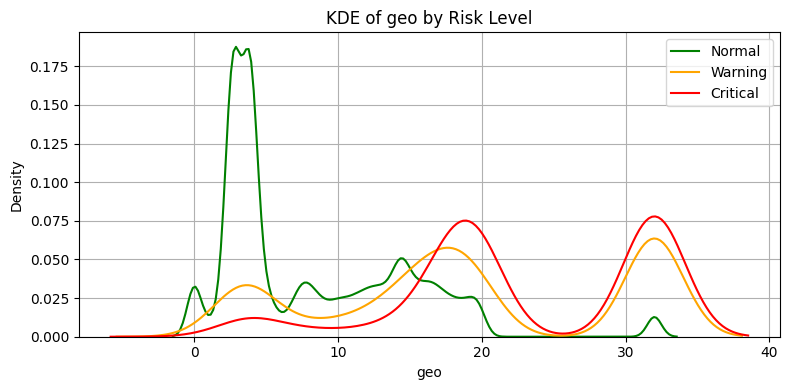

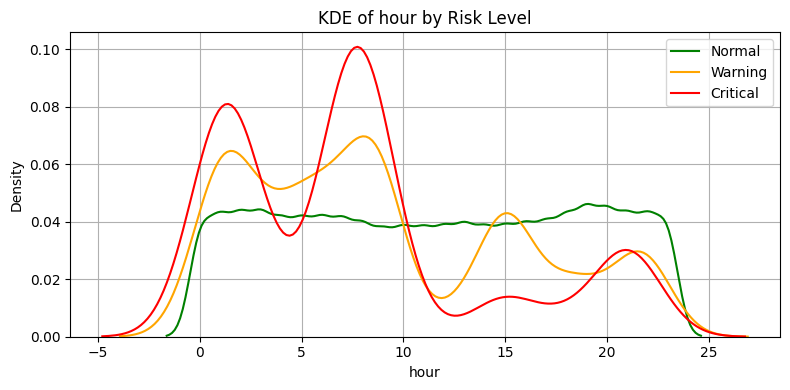

In [249]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14056\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

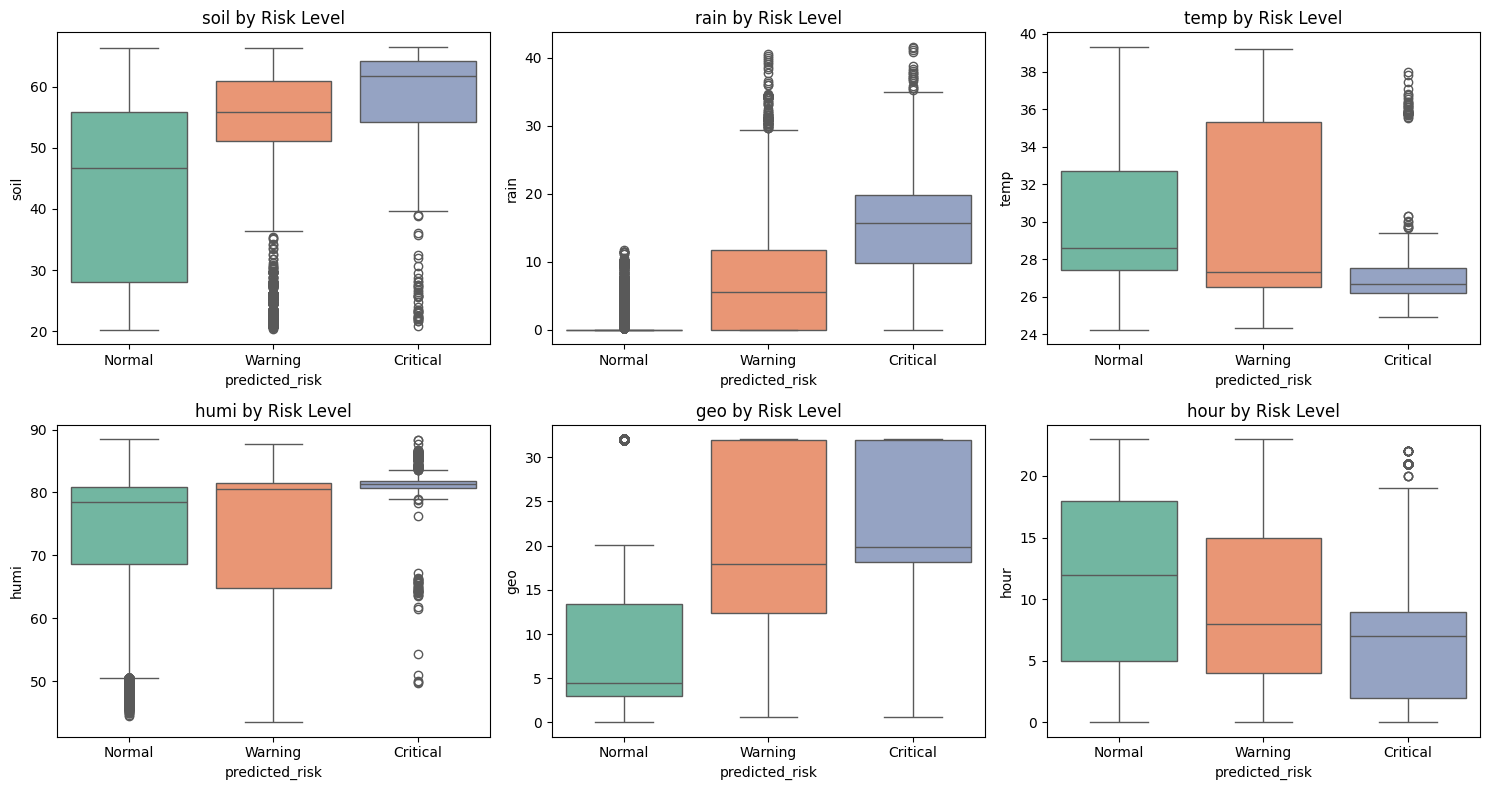

In [250]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [251]:
df['timestamp'].min()

Timestamp('2025-05-02 11:42:00.384119')

In [252]:
df['timestamp'].max()

Timestamp('2025-07-22 19:39:55.017000')

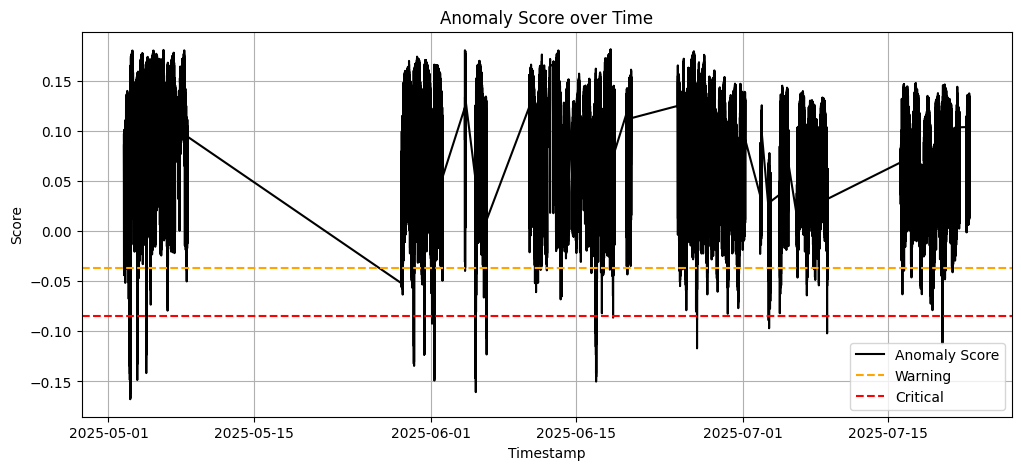

In [253]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

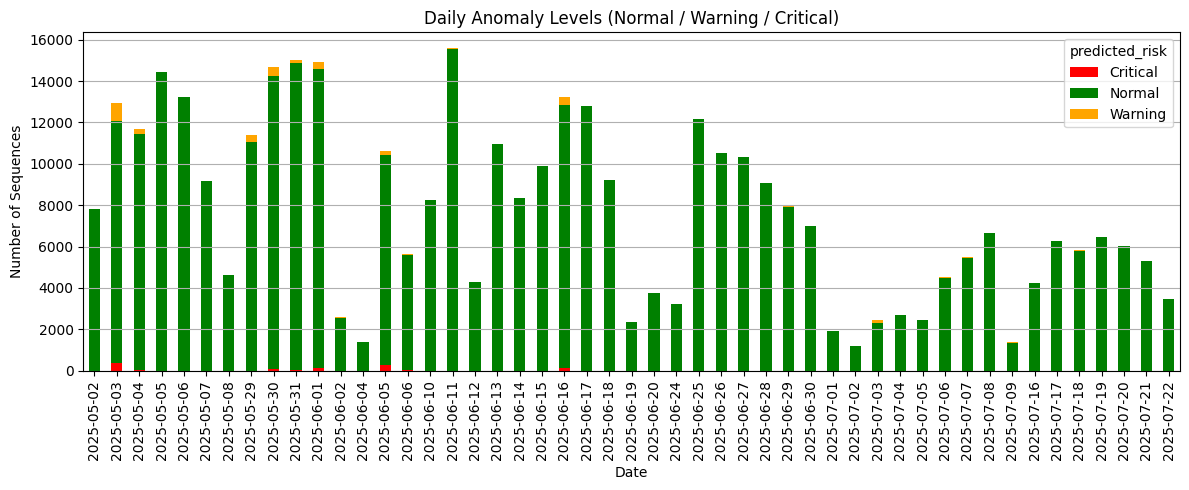

In [254]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


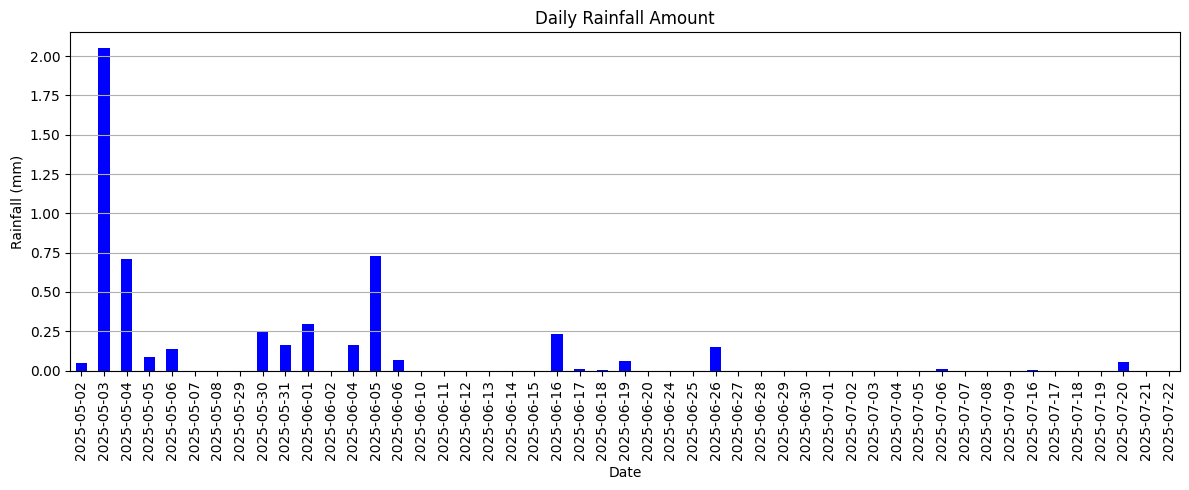

In [255]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


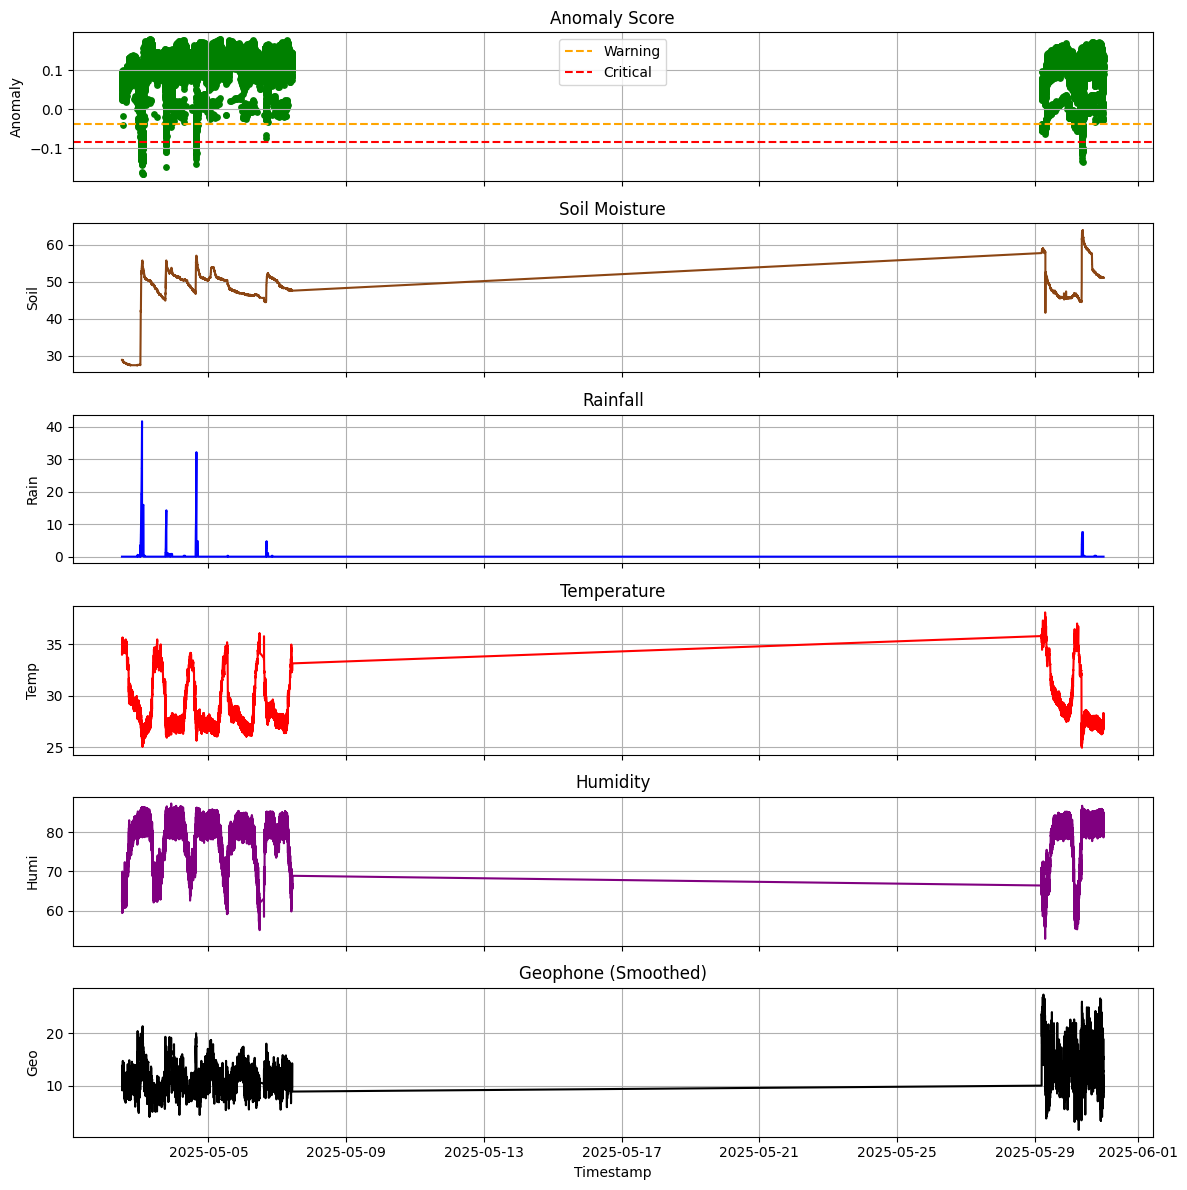

In [256]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-05-02":"2025-05-30"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


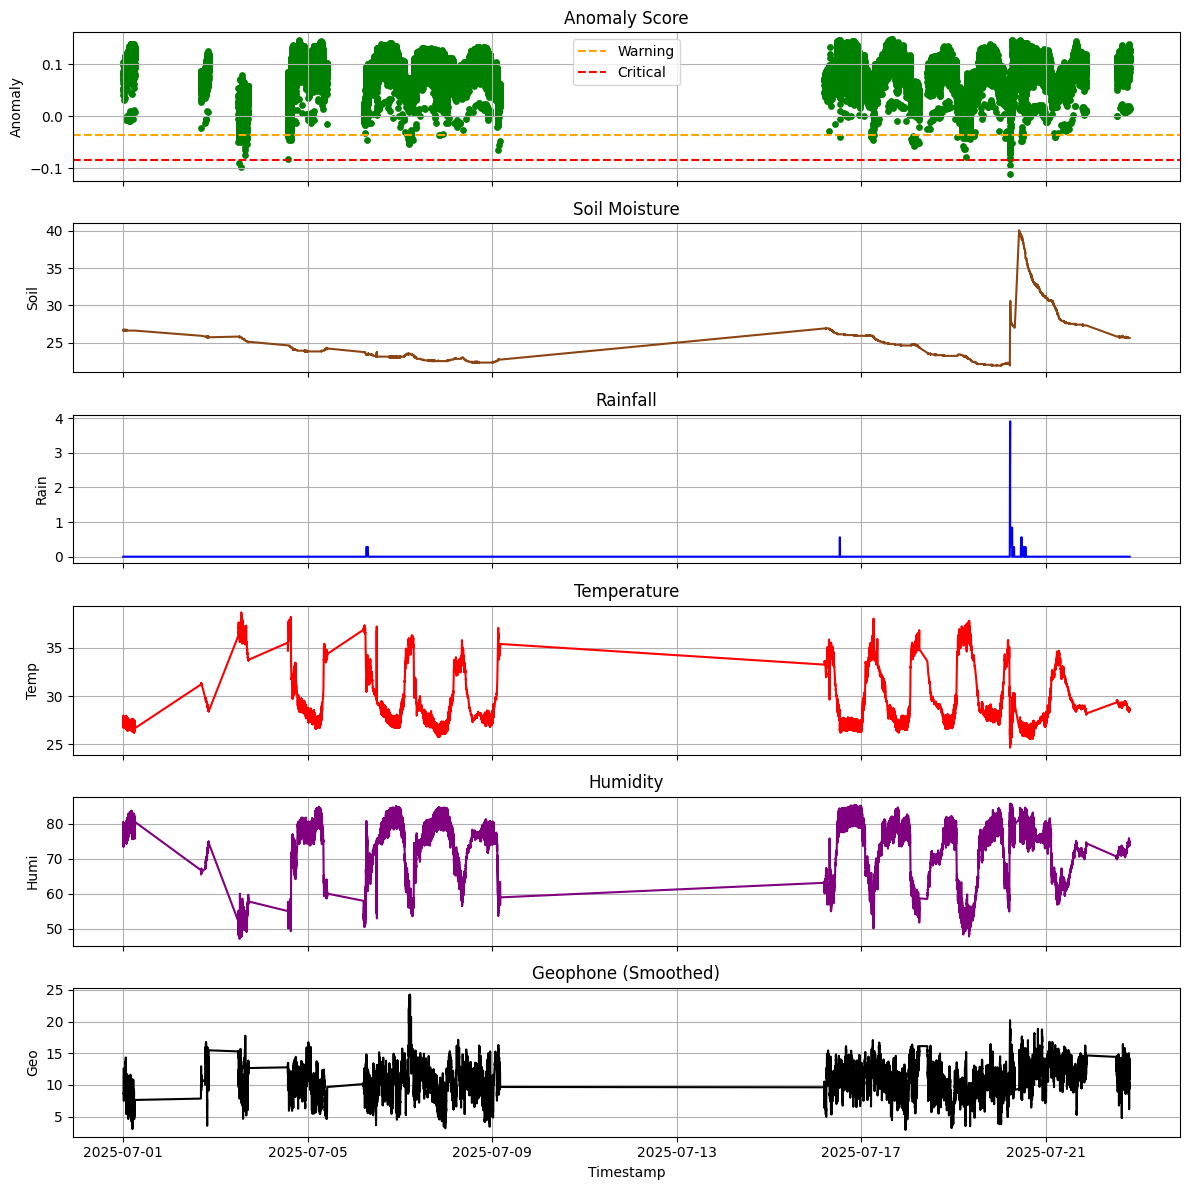

In [257]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-07-01":"2025-07-31"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


# data never learn before

In [258]:
df_val2 = pd.read_csv("./../../data/dataSet2_prepared.csv")
df_val2 = df_val2.sort_values('timestamp').reset_index(drop=True)
df_val2

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
0,2025-07-30 03:28:43.522,101,24.400000,0.0,35.753414,54.635536,17.443285,8.638051,99.898964,3,2
1,2025-07-30 03:28:44.756,102,20.900000,0.0,36.623943,51.436863,2.512411,8.637977,99.898933,3,2
2,2025-07-30 03:28:45.992,101,24.500000,0.0,35.700008,54.654610,11.029456,8.638051,99.898964,3,2
3,2025-07-30 03:28:47.259,101,24.400000,0.0,35.673306,55.825741,8.358195,8.638053,99.898964,3,2
4,2025-07-30 03:28:48.473,102,20.900000,0.0,36.591900,53.292744,2.527225,8.637976,99.898933,3,2
...,...,...,...,...,...,...,...,...,...,...,...
34155,2025-08-03 07:43:15.179,101,26.299999,0.0,34.415577,70.317993,2.514839,8.638032,99.898972,7,6
34156,2025-08-03 07:43:24.004,102,23.400000,0.0,35.267414,69.381470,3.813702,8.637955,99.898911,7,6
34157,2025-08-03 07:43:26.139,101,26.299999,0.0,34.388874,70.276031,10.165874,8.638032,99.898972,7,6
34158,2025-08-03 07:43:35.249,102,23.400000,0.0,35.286106,65.318764,3.002546,8.637956,99.898911,7,6


In [259]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'hour']
X_val2 = df_val2[feature_cols].values  # ใช้ .values แค่กับตัวที่เอาไป scale
X_val2_scaled = scaler.transform(X_val2)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val2['anomaly_score'] = iso_model.decision_function(X_val2_scaled)


def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val2['predicted_risk'] = df_val2['anomaly_score'].apply(classify_risk)


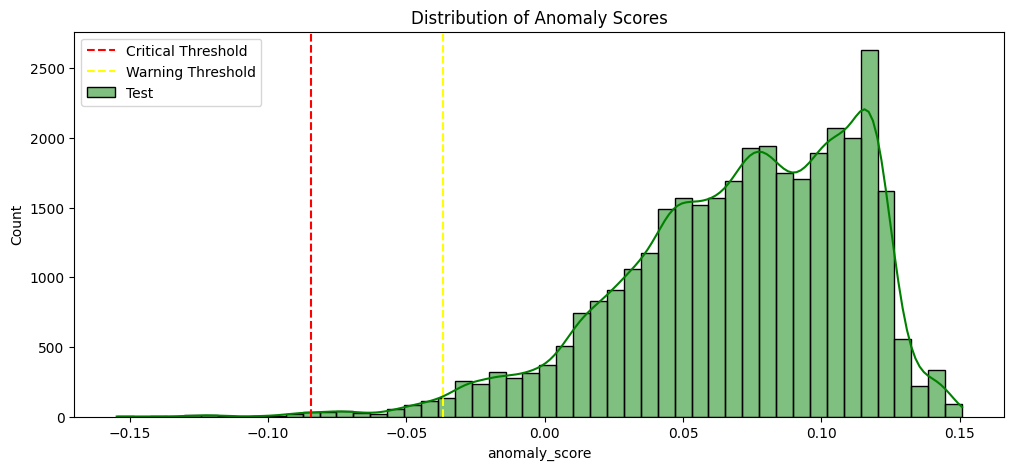

In [260]:
plt.figure(figsize=(12,5))
sns.histplot(df_val2['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



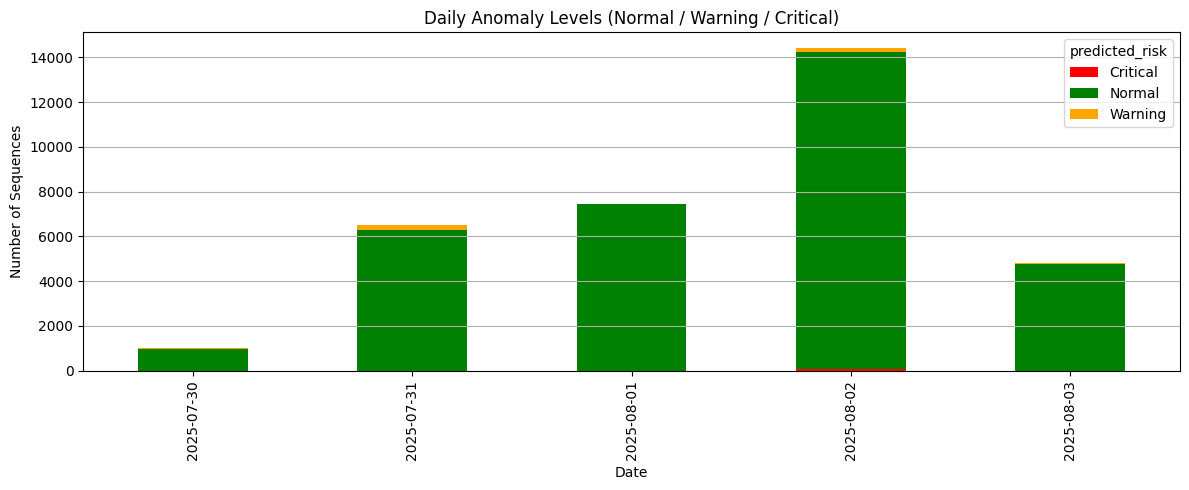

In [261]:

df_results = df_val2
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


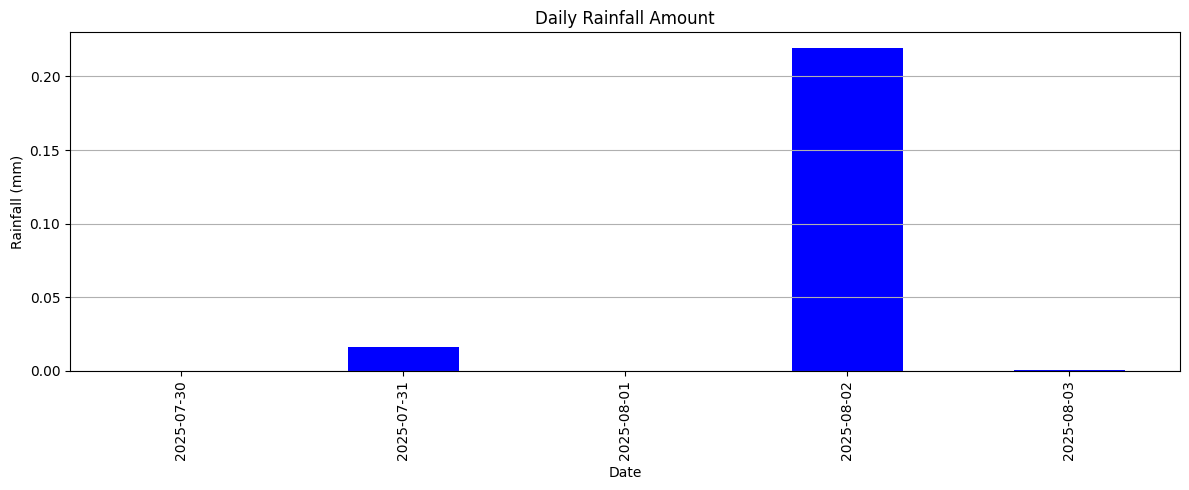

In [262]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


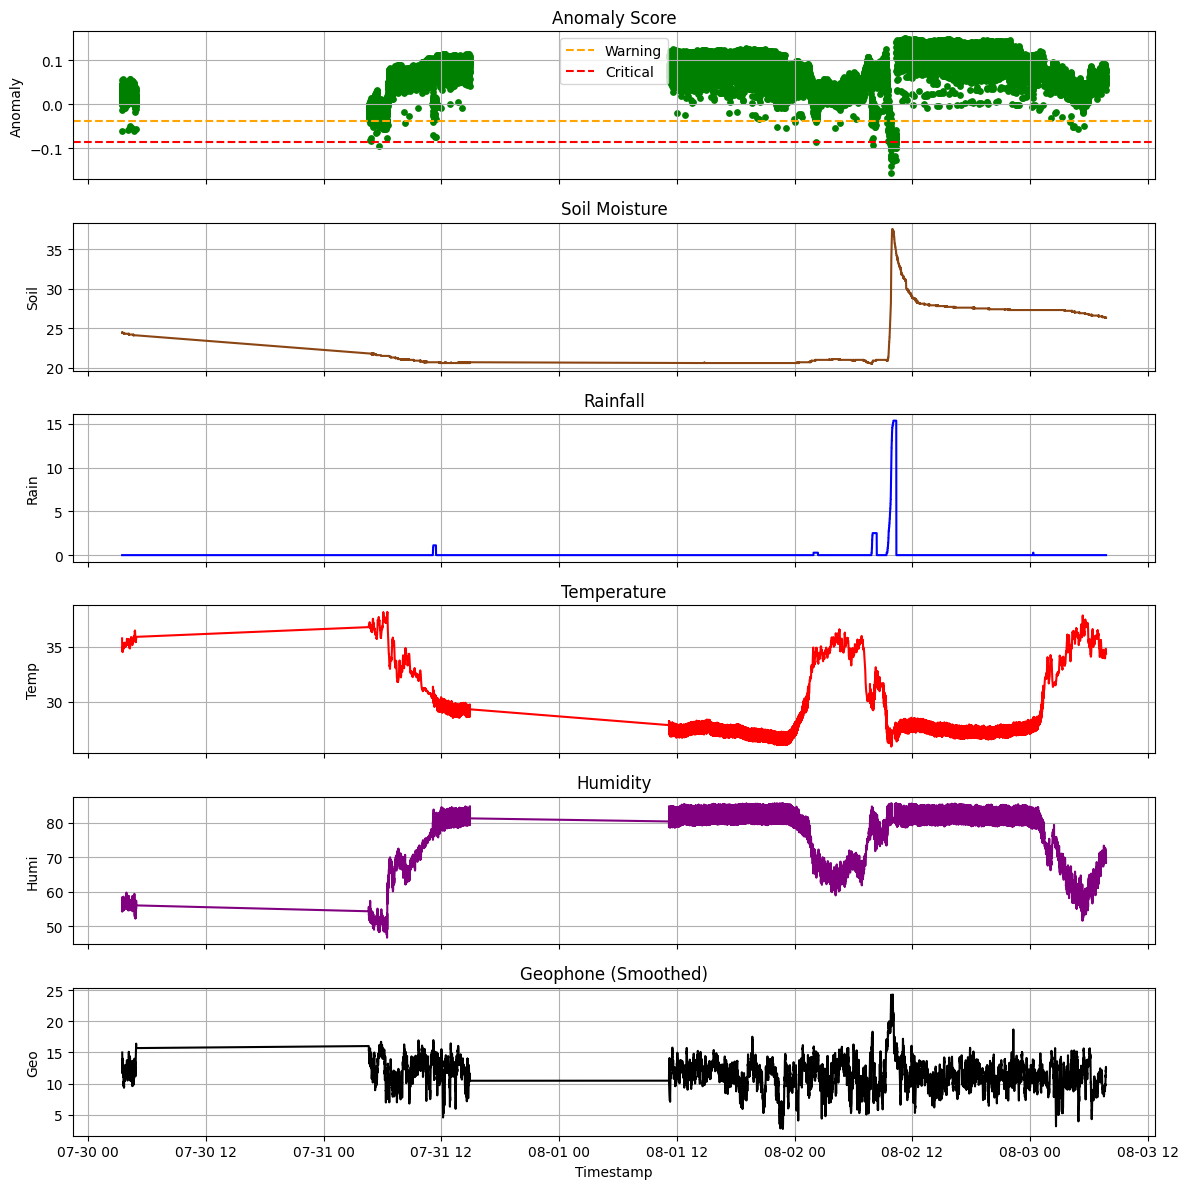

In [263]:
df_val2['timestamp'] = pd.to_datetime(df_val2['timestamp'])
df_dev = df_val2.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-07-30":"2025-08-04"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()
